### European wholesale electricity price data
https://ember-climate.org/data-catalogue/european-wholesale-electricity-price-data/

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests, io
import pandas as pd
url = 'https://ember-climate.org/app/uploads/2022/09/european_wholesale_electricity_price_data_monthly-5.csv'
df = pd.read_csv(io.StringIO(requests.get(url).text))
df = df[df.Country == 'France'].drop(columns=['Country','ISO3 Code']).rename(columns={'Price (EUR/MWhe)':'Price'}).set_index('Date')
df.index = pd.date_range(df.index.min(), periods=len(df), freq="M")
df.T

,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
Price,41.95,50.14,43.79,39.52,26.46,32.16,37.91,32.19,37.45,44.96,...,400.95,492.99,393.55,178.89,192.16,270.49,132.28,148.78,111.81,106.45


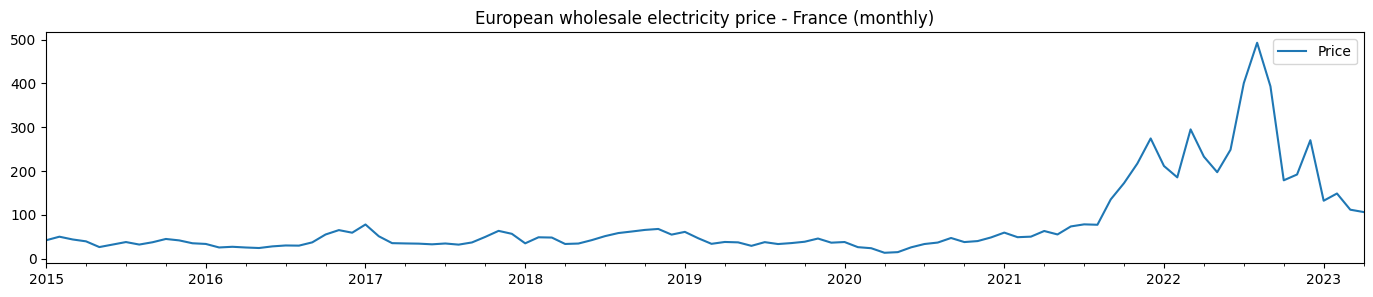

In [2]:
df.plot(figsize=(17,3), title='European wholesale electricity price - France (monthly)');

### Forecast from 2021-09-30

#### Train and Test split

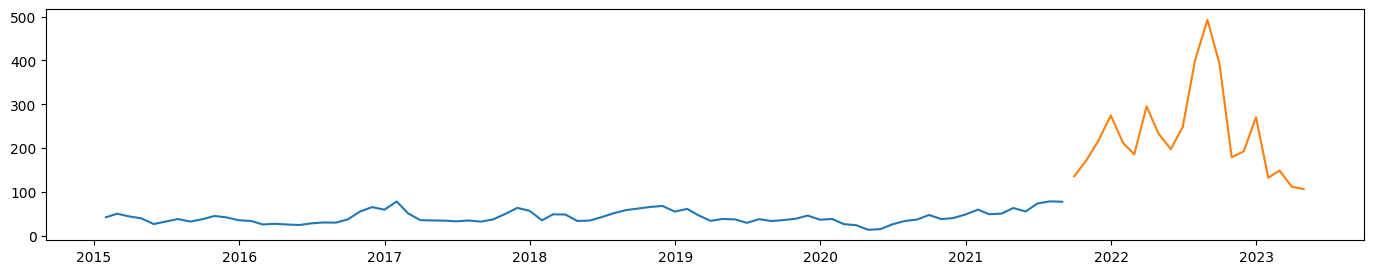

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,3))
train = df.loc[:'2021-08-31']
test = df.loc['2021-09-30':]
plt.plot(train)
plt.plot(test);

#### PACF

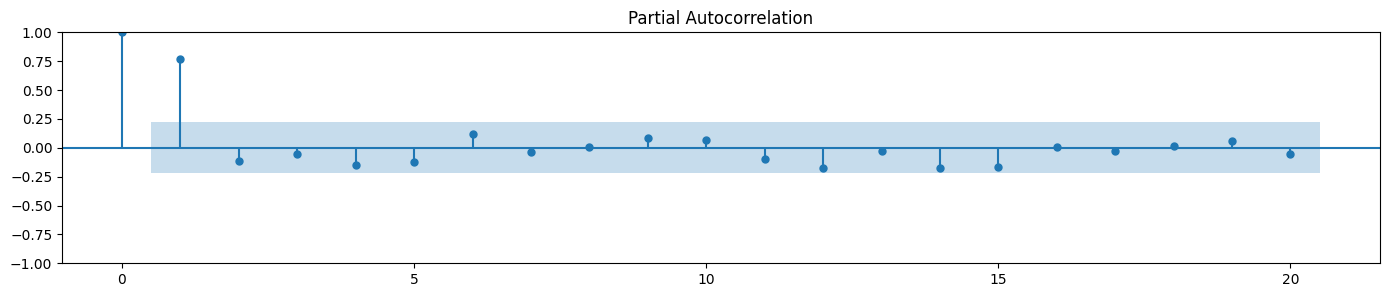

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17,3)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(train);

We see 1-2 AR lags

#### KPSS test

In [15]:
import warnings
warnings.filterwarnings('ignore')
%precision 6
from statsmodels.tsa.stattools import kpss
KPSS = kpss(train)
KPSS

(0.180899,
 0.100000,
 4,
 {'10%': 0.347000, '5%': 0.463000, '2.5%': 0.574000, '1%': 0.739000})

So we fail to reject the Null hypothesis of stationarity with alpha 0.1

#### SARIMA

In [5]:
import statsmodels.api as sm
fit = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), seasonal_order=(2, 1, 0, 12)).fit(disp=0)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                   80
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -249.339
Date:                            Mon, 22 May 2023   AIC                            506.679
Time:                                    14:11:45   BIC                            515.557
Sample:                                01-31-2015   HQIC                           510.197
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8474      0.063     13.446      0.000       0.724       0.971
ar.S.L12      -0.9003      0.115     -7.827      0.000      -1.126      -0.675
ar.S.L24      -0.4235      0.103     -4.126      0.000      -0.625      -0.222
sigma2        75.2501     12.628      5.959      0.000      50.501     100.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.71   Prob(JB):                         0.80
Heteroskedasticity (H):               1.39   Skew:                             0.01
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

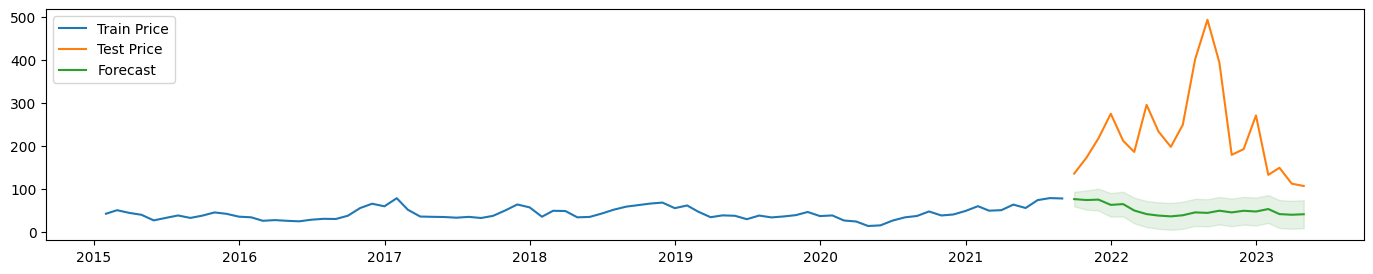

In [8]:
prediction = fit.get_forecast(steps=len(test))
pred = prediction.predicted_mean
ci = prediction.conf_int()
plt.plot(train, label='Train Price')
plt.plot(test, label='Test Price')
plt.plot(pred, label='Forecast')
plt.fill_between(ci.index, ci['lower Price'], ci['upper Price'], color='g', alpha=0.1)
plt.legend(loc='upper left');

### Model search iterations (by predict error) ---> Overfitting

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from itertools import product
errors = []
order = []
season = []
for i in product([0, 1, 2], repeat=3):
    for j in product([0, 1, 2], repeat=3):
        try: 
            fit = sm.tsa.statespace.SARIMAX(train, order=i, seasonal_order=j+(12,)).fit(disp=0)
            errors.append(rmse(fit.get_forecast(steps=len(test)).predicted_mean, test).sum())
            order.append(i)
            season.append(j+(12,))
            print('SARIMAX'+i+(j+(12,)))
        except:
            pass
results = pd.DataFrame({'Order':order, 'Seasonal':season, 'RMSE':errors})
results.sort_values('RMSE', inplace=True, ignore_index=True)
results.head()

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22497D+00    |proj g|=  4.97380D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.974D-09   5.225D+00
  F =   5.2249667396568924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76823D+00    |proj g|=  8.04131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   3.938D-07   3.762D+00
  F =   3.7623027246783294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.7

 This problem is unconstrained.



At iterate   20    f=  3.54105D+00    |proj g|=  8.66033D-04

At iterate   25    f=  3.54102D+00    |proj g|=  2.09454D-04

At iterate   30    f=  3.54102D+00    |proj g|=  2.92931D-04

At iterate   35    f=  3.54102D+00    |proj g|=  1.07217D-04

At iterate   40    f=  3.54102D+00    |proj g|=  3.37856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     43     49      1     0     0   1.480D-05   3.541D+00
  F =   3.5410169420025666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.28035D+00    |proj g|=  6.51239D-04

At iterate   20    f=  3.27995D+00    |proj g|=  4.97418D-05

At iterate   25    f=  3.27992D+00    |proj g|=  4.01670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     30      1     0     0   8.596D-06   3.280D+00
  F =   3.2799127676438102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45721D+00    |proj g|=  3.65735D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  3.20528D+00    |proj g|=  7.73715D-04

At iterate   20    f=  3.20497D+00    |proj g|=  1.33817D-04

At iterate   25    f=  3.20493D+00    |proj g|=  1.14896D-04

At iterate   30    f=  3.20492D+00    |proj g|=  2.71022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     34      1     0     0   9.801D-06   3.205D+00
  F =   3.2049235180764009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.41324D+00    |proj g|=  1.24567D-01

At iterate   10    f=  4.37261D+00    |proj g|=  1.00188D-02

At iterate   15    f=  4.36825D+00    |proj g|=  4.07584D-03

At iterate   20    f=  4.36762D+00    |proj g|=  1.79353D-03

At iterate   25    f=  4.36738D+00    |proj g|=  5.33749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     50      1     0     0   5.316D-04   4.367D+00
  F =   4.3673790812790152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69856D+00    |proj g|=  5.87514D+00

At iterate    5    f=  4.61229D+00    |proj g|=  4.26831D-01

At iterate   10    f=  4.37834D+00    |proj g|=  4.94701D-02

At iterate   15    f=  4.32825D+00    |proj g|=  2.04594D-02

At iterate   20    f=  4.32082D+00    |proj g|=  7.24567D-03

At iterate   25    f=  4.31871D+00    |proj g|=  1.89215D-03

At iterate   30    f=  4.31857D+00    |proj g|=  6.67524D-04

At iterate   35    f=  4.31854D+00    |proj g|=  3.10048D-05

At iterate   40    f=  4.31853D+00    |proj g|=  2.30992D-04

At iterate   45    f=  4.31853D+00    |proj g|=  3.02800D-05

At iterate   50    f=  4.31852D+00    |proj g|=  1.85639D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.63242D+00    |proj g|=  1.03499D-01

At iterate   10    f=  3.58697D+00    |proj g|=  1.38714D-02

At iterate   15    f=  3.56807D+00    |proj g|=  9.78506D-04

At iterate   20    f=  3.56735D+00    |proj g|=  1.48089D-02

At iterate   25    f=  3.56622D+00    |proj g|=  5.93033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     38      1     0     0   5.370D-06   3.566D+00
  F =   3.5662189651034488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   20    f=  3.53791D+00    |proj g|=  2.03143D-03

At iterate   25    f=  3.53773D+00    |proj g|=  3.81925D-04

At iterate   30    f=  3.53770D+00    |proj g|=  4.48252D-04

At iterate   35    f=  3.53770D+00    |proj g|=  1.98823D-04

At iterate   40    f=  3.53770D+00    |proj g|=  6.51864D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     48      1     0     0   3.153D-05   3.538D+00
  F =   3.5376993504066632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.29975D+00    |proj g|=  4.19194D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   4.192D-06   3.300D+00
  F =   3.2997549277282134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32452D+00    |proj g|=  4.55331D-02

At iterate    5    f=  3.29752D+00    |proj g|=  1.33456D-02

At iterate   10    f=  3.22846D+00    |proj g|=  9.20539D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  3.31880D+00    |proj g|=  1.03459D-02

At iterate   10    f=  3.29395D+00    |proj g|=  6.95368D-02

At iterate   15    f=  3.25612D+00    |proj g|=  2.58750D-02

At iterate   20    f=  3.20275D+00    |proj g|=  3.04812D-03

At iterate   25    f=  3.20263D+00    |proj g|=  7.36126D-04

At iterate   30    f=  3.20245D+00    |proj g|=  7.25443D-04

At iterate   35    f=  3.20242D+00    |proj g|=  2.97007D-04

At iterate   40    f=  3.20241D+00    |proj g|=  3.16266D-04

At iterate   45    f=  3.20241D+00    |proj g|=  2.81862D-05

At iterate   50    f=  3.20241D+00    |proj g|=  1.11146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06894D+00    |proj g|=  4.80709D+00

At iterate    5    f=  4.41827D+00    |proj g|=  2.79661D-02

At iterate   10    f=  4.40938D+00    |proj g|=  6.41560D-03

At iterate   15    f=  4.40763D+00    |proj g|=  1.78272D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   8.127D-08   4.408D+00
  F =   4.4076267059274015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  4.34652D+00    |proj g|=  6.89158D-03

At iterate   15    f=  4.34480D+00    |proj g|=  8.66682D-03

At iterate   20    f=  4.34342D+00    |proj g|=  2.11422D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   1.422D-04   4.343D+00
  F =   4.3434141049094546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00484D+01    |proj g|=  9.67864D+00


 This problem is unconstrained.



At iterate    5    f=  4.41507D+00    |proj g|=  1.53327D-01

At iterate   10    f=  4.35661D+00    |proj g|=  9.62602D-03

At iterate   15    f=  4.35640D+00    |proj g|=  4.76143D-04

At iterate   20    f=  4.35635D+00    |proj g|=  2.10724D-03

At iterate   25    f=  4.35631D+00    |proj g|=  1.82814D-04

At iterate   30    f=  4.35624D+00    |proj g|=  6.62132D-03

At iterate   35    f=  4.35584D+00    |proj g|=  8.69729D-03

At iterate   40    f=  4.35421D+00    |proj g|=  5.23686D-02

At iterate   45    f=  4.34472D+00    |proj g|=  6.52503D-02


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  4.31949D+00    |proj g|=  2.98107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   2.981D-02   4.319D+00
  F =   4.3194906430986153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61468D+00    |proj g|=  1.03204D-01

At iterate    5    f=  3.58350D+00    |proj g|=  2.52547D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  3.61581D+00    |proj g|=  2.63132D-02

At iterate   10    f=  3.54340D+00    |proj g|=  3.64165D-02

At iterate   15    f=  3.52939D+00    |proj g|=  4.71533D-03

At iterate   20    f=  3.52926D+00    |proj g|=  2.34035D-03

At iterate   25    f=  3.52897D+00    |proj g|=  1.71935D-03

At iterate   30    f=  3.52891D+00    |proj g|=  6.99787D-04

At iterate   35    f=  3.52890D+00    |proj g|=  4.08769D-04

At iterate   40    f=  3.52889D+00    |proj g|=  1.91359D-04

At iterate   45    f=  3.52889D+00    |proj g|=  5.53658D-05

At iterate   50    f=  3.52889D+00    |proj g|=  5.82232D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.26178D+00    |proj g|=  1.94489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   8.155D-06   3.261D+00
  F =   3.2609348572390866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34119D+00    |proj g|=  1.15425D-01


 This problem is unconstrained.



At iterate    5    f=  3.27529D+00    |proj g|=  2.70415D-02

At iterate   10    f=  3.24893D+00    |proj g|=  7.72905D-02

At iterate   15    f=  3.21454D+00    |proj g|=  9.32398D-03

At iterate   20    f=  3.21179D+00    |proj g|=  1.59570D-03

At iterate   25    f=  3.21158D+00    |proj g|=  6.89735D-04

At iterate   30    f=  3.21154D+00    |proj g|=  2.17732D-04

At iterate   35    f=  3.21154D+00    |proj g|=  5.89039D-05

At iterate   40    f=  3.21154D+00    |proj g|=  3.79986D-05

At iterate   45    f=  3.21154D+00    |proj g|=  5.28994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     54   

 This problem is unconstrained.



At iterate    5    f=  3.31762D+00    |proj g|=  1.20830D-02

At iterate   10    f=  3.26641D+00    |proj g|=  1.71538D-01

At iterate   15    f=  3.21376D+00    |proj g|=  5.87421D-03

At iterate   20    f=  3.19989D+00    |proj g|=  7.48064D-04

At iterate   25    f=  3.19971D+00    |proj g|=  1.19771D-03

At iterate   30    f=  3.19965D+00    |proj g|=  5.62131D-03

At iterate   35    f=  3.19956D+00    |proj g|=  1.00511D-03

At iterate   40    f=  3.19954D+00    |proj g|=  2.68769D-04

At iterate   45    f=  3.19953D+00    |proj g|=  2.19219D-04


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  3.19953D+00    |proj g|=  1.70659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.707D-04   3.200D+00
  F =   3.1995314109804704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96834D+00    |proj g|=  1.16661D-02

At iterate    5    f=  4.67976D+00    |proj g|=  6.54536D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   15    f=  4.43518D+00    |proj g|=  4.13330D-02

At iterate   20    f=  4.36875D+00    |proj g|=  1.60825D-03

At iterate   25    f=  4.36850D+00    |proj g|=  9.54017D-03

At iterate   30    f=  4.36810D+00    |proj g|=  3.20203D-03

At iterate   35    f=  4.36805D+00    |proj g|=  3.45768D-04

At iterate   40    f=  4.36804D+00    |proj g|=  3.72832D-05

At iterate   45    f=  4.36804D+00    |proj g|=  1.80337D-04

At iterate   50    f=  4.36804D+00    |proj g|=  8.85976D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62      1     0     0   8.860D-06   4.368D+00
  F =   4.36803677280

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.32127D+00    |proj g|=  3.73018D-02

At iterate   10    f=  3.30843D+00    |proj g|=  3.06316D-03

At iterate   15    f=  3.30737D+00    |proj g|=  2.48224D-04

At iterate   20    f=  3.30727D+00    |proj g|=  4.33294D-04

At iterate   25    f=  3.30725D+00    |proj g|=  8.32479D-05

At iterate   30    f=  3.30725D+00    |proj g|=  1.13898D-04

At iterate   35    f=  3.30725D+00    |proj g|=  2.43602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     45      1     0     0   6.243D-06   3.307D+00
  F =   3.3072473363583041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   15    f=  3.27726D+00    |proj g|=  1.92866D-02

At iterate   20    f=  3.27575D+00    |proj g|=  6.19041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   3.325D-06   3.276D+00
  F =   3.2757517214528975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26975D+00    |proj g|=  3.20745D-02

At iterate    5    f=  3.25184D+00    |proj g|=  4.23950D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     11      1     0     0   7.023D-06   3.248D+00
  F =   3.2475357897755628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26975D+00    |proj g|=  2.70269D-01


 This problem is unconstrained.



At iterate    5    f=  3.15128D+00    |proj g|=  9.83921D-02

At iterate   10    f=  3.05813D+00    |proj g|=  6.37156D-03

At iterate   15    f=  3.05416D+00    |proj g|=  8.12383D-04

At iterate   20    f=  3.05368D+00    |proj g|=  1.80656D-04

At iterate   25    f=  3.05363D+00    |proj g|=  7.16161D-05

At iterate   30    f=  3.05363D+00    |proj g|=  1.34745D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     35      1     0     0   8.188D-06   3.054D+00
  F =   3.0536286591034956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.17286D+00    |proj g|=  1.53801D-02

At iterate   10    f=  2.98957D+00    |proj g|=  1.83281D-02

At iterate   15    f=  2.98526D+00    |proj g|=  1.57901D-03

At iterate   20    f=  2.98087D+00    |proj g|=  8.88952D-03

At iterate   25    f=  2.97629D+00    |proj g|=  4.69870D-04

At iterate   30    f=  2.97626D+00    |proj g|=  1.21976D-03

At iterate   35    f=  2.97623D+00    |proj g|=  2.41929D-04

At iterate   40    f=  2.97623D+00    |proj g|=  4.08698D-05

At iterate   45    f=  2.97623D+00    |proj g|=  1.18902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     62   

 This problem is unconstrained.



At iterate   10    f=  4.17583D+00    |proj g|=  2.66793D-02

At iterate   15    f=  4.17158D+00    |proj g|=  4.69676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     34      1     0     0   5.444D-06   4.172D+00
  F =   4.1715744807306212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88204D+00    |proj g|=  1.86256D-02


 This problem is unconstrained.



At iterate    5    f=  4.72693D+00    |proj g|=  2.04434D-02

At iterate   10    f=  4.13772D+00    |proj g|=  6.05205D-02

At iterate   15    f=  4.02292D+00    |proj g|=  7.78441D-03

At iterate   20    f=  4.00839D+00    |proj g|=  1.23627D-02

At iterate   25    f=  4.00454D+00    |proj g|=  7.02885D-03
  ys=-1.178E-04  -gs= 2.913E-04 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  4.00392D+00    |proj g|=  4.41929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     57      1     1     0   4.419D-03   4.004D+00
  F =   4.0039214793868592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96834D+00    |proj g|=  3.15743D-01

At iterate    5    f=  4.85770D+00    |proj g|=  3.85117D-02

At iterate   10    f=  4.65310D+00    |proj g|=  8.79492D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49341D+00    |proj g|=  7.11853D-02

At iterate    5    f=  3.36871D+00    |proj g|=  8.95500D-02

At iterate   10    f=  3.36072D+00    |proj g|=  1.46605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.236D-06   3.361D+00
  F =   3.3607248367040041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.43478D+00    |proj g|=  4.96859D-02

At iterate   10    f=  3.27392D+00    |proj g|=  2.03798D-02

At iterate   15    f=  3.27212D+00    |proj g|=  2.76977D-03

At iterate   20    f=  3.27155D+00    |proj g|=  1.54863D-03

At iterate   25    f=  3.27143D+00    |proj g|=  6.39616D-04

At iterate   30    f=  3.27140D+00    |proj g|=  3.13051D-04

At iterate   35    f=  3.27139D+00    |proj g|=  1.93245D-04

At iterate   40    f=  3.27139D+00    |proj g|=  3.68363D-05

At iterate   45    f=  3.27139D+00    |proj g|=  9.03313D-05


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.27139D+00    |proj g|=  3.79178D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   3.792D-05   3.271D+00
  F =   3.2713932794450025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22115D+00    |proj g|=  6.35190D-02

At iterate    5    f=  3.14409D+00    |proj g|=  3.30834D-02

At iterate   10    f=  3.07678D+00    |proj g|=  1.72580D-03

       

 This problem is unconstrained.



At iterate   10    f=  3.00862D+00    |proj g|=  8.33749D-02

At iterate   15    f=  2.99766D+00    |proj g|=  9.77631D-05

At iterate   20    f=  2.99763D+00    |proj g|=  1.02982D-03

At iterate   25    f=  2.99758D+00    |proj g|=  1.43428D-03

At iterate   30    f=  2.99757D+00    |proj g|=  1.22709D-04

At iterate   35    f=  2.99757D+00    |proj g|=  3.33286D-05

At iterate   40    f=  2.99757D+00    |proj g|=  5.82689D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     51      1     0     0   5.827D-06   2.998D+00
  F =   2.9975734454839675     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.17968D+00    |proj g|=  1.48336D-02

At iterate   10    f=  3.01847D+00    |proj g|=  1.27437D-02

At iterate   15    f=  3.01378D+00    |proj g|=  1.36294D-02

At iterate   20    f=  2.97600D+00    |proj g|=  1.76539D-02

At iterate   25    f=  2.97534D+00    |proj g|=  1.00419D-03

At iterate   30    f=  2.97528D+00    |proj g|=  7.92615D-04

At iterate   35    f=  2.97527D+00    |proj g|=  4.73217D-04

At iterate   40    f=  2.97526D+00    |proj g|=  2.84510D-05

At iterate   45    f=  2.97526D+00    |proj g|=  4.15055D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96834D+00    |proj g|=  3.15743D-01

At iterate    5    f=  4.83905D+00    |proj g|=  2.16016D-02

At iterate   10    f=  4.42826D+00    |proj g|=  3.65697D-01

At iterate   15    f=  4.13722D+00    |proj g|=  2.72059D-02

At iterate   20    f=  4.05242D+00    |proj g|=  3.58853D-03

At iterate   25    f=  4.05232D+00    |proj g|=  8.61808D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00849D+00    |proj g|=  1.50879D-01

At iterate    5    f=  4.82368D+00    |proj g|=  5.07153D-02

At iterate   10    f=  4.18069D+00    |proj g|=  1.35703D-01

At iterate   15    f=  3.98841D+00    |proj g|=  2.26524D-02

At iterate   20    f=  3.98638D+00    |proj g|=  6.80365D-04

At iterate   25    f=  3.98613D+00    |proj g|=  6.39016D-03

At iterate   30    f=  3.98571D+00    |proj g|=  8.06938D-04

At iterate   35    f=  3.98571D+00    |proj g|=  1.14921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  4.84522D+00    |proj g|=  2.81618D-02

At iterate   10    f=  4.32730D+00    |proj g|=  2.04953D-01

At iterate   15    f=  4.01592D+00    |proj g|=  3.45343D-02

At iterate   20    f=  4.00392D+00    |proj g|=  1.81392D-02

At iterate   25    f=  4.00384D+00    |proj g|=  1.16053D-02

At iterate   30    f=  4.00383D+00    |proj g|=  7.08183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     69      1     0     0   7.082D-03   4.004D+00
  F =   4.0038305288969251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.29256D+00    |proj g|=  2.92562D-03

At iterate   15    f=  3.29225D+00    |proj g|=  5.05818D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   5.058D-07   3.292D+00
  F =   3.2922456124827710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63232D+00    |proj g|=  1.30374D-01


 This problem is unconstrained.



At iterate    5    f=  3.43835D+00    |proj g|=  5.05716D-02

At iterate   10    f=  3.35660D+00    |proj g|=  5.88537D-03

At iterate   15    f=  3.35458D+00    |proj g|=  4.21859D-03

At iterate   20    f=  3.31805D+00    |proj g|=  1.11724D-01

At iterate   25    f=  3.27336D+00    |proj g|=  6.41908D-03

At iterate   30    f=  3.27314D+00    |proj g|=  1.44793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   6.766D-06   3.273D+00
  F =   3.2731431118597727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  3.32207D+00    |proj g|=  6.90175D-02

At iterate   15    f=  3.26723D+00    |proj g|=  1.30212D-02

At iterate   20    f=  3.26657D+00    |proj g|=  8.10703D-04

At iterate   25    f=  3.26644D+00    |proj g|=  8.50566D-03

At iterate   30    f=  3.26615D+00    |proj g|=  2.77887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   9.143D-06   3.266D+00
  F =   3.2661502577464971     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  3.06414D+00    |proj g|=  1.42208D-01

At iterate   15    f=  3.03832D+00    |proj g|=  2.22442D-03

At iterate   20    f=  3.01416D+00    |proj g|=  5.51564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   5.077D-06   3.014D+00
  F =   3.0140670967505239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26827D+00    |proj g|=  1.30147D-01


 This problem is unconstrained.



At iterate    5    f=  3.18440D+00    |proj g|=  1.49515D-02

At iterate   10    f=  3.04782D+00    |proj g|=  4.00104D-02

At iterate   15    f=  2.97955D+00    |proj g|=  3.85133D-02

At iterate   20    f=  2.97779D+00    |proj g|=  5.04438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   1.466D-05   2.978D+00
  F =   2.9777937169574886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  3.04702D+00    |proj g|=  1.99297D-01

At iterate   15    f=  2.97584D+00    |proj g|=  2.02294D-02

At iterate   20    f=  2.97109D+00    |proj g|=  2.18008D-03

At iterate   25    f=  2.97106D+00    |proj g|=  1.47541D-03

At iterate   30    f=  2.97099D+00    |proj g|=  9.78162D-04

At iterate   35    f=  2.97096D+00    |proj g|=  4.63346D-04

At iterate   40    f=  2.97095D+00    |proj g|=  2.89350D-04

At iterate   45    f=  2.97095D+00    |proj g|=  2.99824D-04


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.97095D+00    |proj g|=  5.13892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   5.139D-05   2.971D+00
  F =   2.9709515887703555     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82217D+00    |proj g|=  4.05094D-02

At iterate    5    f=  4.66489D+00    |proj g|=  1.17643D-01

At iterate   10    f=  4.36720D+00    |proj g|=  7.25238D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82217D+00    |proj g|=  8.97933D-02

At iterate    5    f=  4.77298D+00    |proj g|=  5.18667D-02

At iterate   10    f=  4.48263D+00    |proj g|=  1.35336D-01

At iterate   15    f=  4.35686D+00    |proj g|=  8.84663D-02

At iterate   20    f=  4.14261D+00    |proj g|=  7.42595D-02

At iterate   25    f=  4.12421D+00    |proj g|=  6.55296D-03

At iterate   30    f=  4.12392D+00    |proj g|=  1.44837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.23639D+00    |proj g|=  4.92618D-03

At iterate   15    f=  3.23447D+00    |proj g|=  2.36077D-03

At iterate   20    f=  3.23416D+00    |proj g|=  5.34189D-04

At iterate   25    f=  3.23411D+00    |proj g|=  6.27546D-04

At iterate   30    f=  3.23410D+00    |proj g|=  2.33954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     43      1     0     0   4.921D-05   3.234D+00
  F =   3.2340958754036224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  3.20321D+00    |proj g|=  1.21839D-02

At iterate   15    f=  3.20163D+00    |proj g|=  2.76053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   1.677D-06   3.202D+00
  F =   3.2016277930148993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26888D+00    |proj g|=  7.83885D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.25145D+00    |proj g|=  1.24707D-02

At iterate   10    f=  3.22385D+00    |proj g|=  5.63066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   6.399D-07   3.224D+00
  F =   3.2237621027467092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26888D+00    |proj g|=  2.99070D-01

At iterate    5    f=  3.17866D+00    |proj g|=  1.46120D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  3.16707D+00    |proj g|=  1.82796D-02

At iterate   10    f=  3.01735D+00    |proj g|=  1.21910D-01

At iterate   15    f=  2.94653D+00    |proj g|=  1.02925D-01

At iterate   20    f=  2.92619D+00    |proj g|=  6.56989D-04

At iterate   25    f=  2.92606D+00    |proj g|=  3.02693D-03

At iterate   30    f=  2.92590D+00    |proj g|=  1.10001D-03

At iterate   35    f=  2.92586D+00    |proj g|=  6.36754D-04

At iterate   40    f=  2.92586D+00    |proj g|=  1.23792D-04

At iterate   45    f=  2.92585D+00    |proj g|=  3.01529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     69   

 This problem is unconstrained.



At iterate   15    f=  4.20420D+00    |proj g|=  5.01933D-01

At iterate   20    f=  4.07783D+00    |proj g|=  7.85719D-02

At iterate   25    f=  4.06842D+00    |proj g|=  4.11376D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     45      1     0     0   9.872D-06   4.068D+00
  F =   4.0684212740322723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85193D+00    |proj g|=  1.82627D-01


 This problem is unconstrained.



At iterate    5    f=  4.78315D+00    |proj g|=  4.14628D-02

At iterate   10    f=  4.42782D+00    |proj g|=  2.48993D-01

At iterate   15    f=  4.12521D+00    |proj g|=  5.83661D-02

At iterate   20    f=  4.01192D+00    |proj g|=  2.56525D-01

At iterate   25    f=  3.90606D+00    |proj g|=  1.42570D-02

At iterate   30    f=  3.89982D+00    |proj g|=  3.49569D-02

At iterate   35    f=  3.89096D+00    |proj g|=  1.62229D-02

At iterate   40    f=  3.88941D+00    |proj g|=  2.06918D-03
  ys=-1.786E-04  -gs= 4.279E-05 BFGS update SKIPPED

At iterate   45    f=  3.88925D+00    |proj g|=  1.25361D-03

At iterate   50    f=  3.88925D+00    |proj g|=  3.03056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82217D+00    |proj g|=  8.97969D-02

At iterate    5    f=  4.79025D+00    |proj g|=  3.92646D-02

At iterate   10    f=  4.73458D+00    |proj g|=  3.14400D-02

At iterate   15    f=  4.30943D+00    |proj g|=  3.89846D-01

At iterate   20    f=  3.90502D+00    |proj g|=  7.70665D-02

At iterate   25    f=  3.85780D+00    |proj g|=  2.25558D-02

At iterate   30    f=  3.85657D+00    |proj g|=  3.18247D-04

At iterate   35    f=  3.85651D+00    |proj g|=  2.90106D-03

At iterate   40    f=  3.85537D+00    |proj g|=  1.05747D-02

At iterate   45    f=  3.85508D+00    |proj g|=  3.70585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.28130D+00    |proj g|=  5.57385D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   5.574D-06   3.281D+00
  F =   3.2813032813111578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46353D+00    |proj g|=  5.21659D-02

At iterate    5    f=  3.38616D+00    |proj g|=  7.07719D-02

At iterate   10    f=  3.22047D+00    |proj g|=  6.97343D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  3.21316D+00    |proj g|=  7.26122D-02

At iterate   15    f=  3.20088D+00    |proj g|=  1.18543D-02

At iterate   20    f=  3.19874D+00    |proj g|=  3.04085D-03

At iterate   25    f=  3.19844D+00    |proj g|=  2.24313D-03

At iterate   30    f=  3.19838D+00    |proj g|=  3.24425D-04

At iterate   35    f=  3.19837D+00    |proj g|=  4.12673D-04

At iterate   40    f=  3.19836D+00    |proj g|=  7.63562D-04

At iterate   45    f=  3.19836D+00    |proj g|=  6.80290D-05


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.19836D+00    |proj g|=  3.90259D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.903D-05   3.198D+00
  F =   3.1983605557610630     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20576D+00    |proj g|=  6.16868D-02

At iterate    5    f=  3.13058D+00    |proj g|=  4.92377D-02

At iterate   10    f=  3.01247D+00    |proj g|=  2.31435D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  3.14063D+00    |proj g|=  3.12143D-02

At iterate   10    f=  2.94589D+00    |proj g|=  7.82977D-02

At iterate   15    f=  2.93738D+00    |proj g|=  3.54589D-04

At iterate   20    f=  2.93733D+00    |proj g|=  4.02899D-03

At iterate   25    f=  2.93719D+00    |proj g|=  1.04893D-03

At iterate   30    f=  2.93717D+00    |proj g|=  9.85707D-04

At iterate   35    f=  2.93716D+00    |proj g|=  3.09822D-04

At iterate   40    f=  2.93716D+00    |proj g|=  4.98562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     57      1     0     0   3.821D-05   2.937D+00
  F =   2.93716251321

 This problem is unconstrained.



At iterate    5    f=  3.16861D+00    |proj g|=  1.58707D-02

At iterate   10    f=  3.04102D+00    |proj g|=  1.06940D-01

At iterate   15    f=  2.92733D+00    |proj g|=  1.12156D-02

At iterate   20    f=  2.92528D+00    |proj g|=  5.14959D-03

At iterate   25    f=  2.92471D+00    |proj g|=  4.99473D-03

At iterate   30    f=  2.92441D+00    |proj g|=  1.59741D-03

At iterate   35    f=  2.92436D+00    |proj g|=  1.45076D-03

At iterate   40    f=  2.92434D+00    |proj g|=  3.71759D-04

At iterate   45    f=  2.92433D+00    |proj g|=  2.29565D-04

At iterate   50    f=  2.92433D+00    |proj g|=  9.81774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82217D+00    |proj g|=  8.97969D-02

At iterate    5    f=  4.78063D+00    |proj g|=  3.30609D-02

At iterate   10    f=  4.68566D+00    |proj g|=  7.26818D-02

At iterate   15    f=  4.12621D+00    |proj g|=  1.11860D-01

At iterate   20    f=  3.97023D+00    |proj g|=  1.66735D-01

At iterate   25    f=  3.92799D+00    |proj g|=  1.59366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.81067D+00    |proj g|=  1.90984D-02

At iterate   10    f=  4.70641D+00    |proj g|=  7.98727D-02

At iterate   15    f=  4.30924D+00    |proj g|=  1.80814D-01

At iterate   20    f=  4.07435D+00    |proj g|=  2.15058D-01

At iterate   25    f=  3.95489D+00    |proj g|=  3.98898D-02

At iterate   30    f=  3.88432D+00    |proj g|=  3.13952D-02

At iterate   35    f=  3.86668D+00    |proj g|=  4.82466D-02

At iterate   40    f=  3.86294D+00    |proj g|=  7.73565D-03

At iterate   45    f=  3.86246D+00    |proj g|=  1.54763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     61   

 This problem is unconstrained.



At iterate    5    f=  4.79046D+00    |proj g|=  4.30965D-02

At iterate   10    f=  4.73612D+00    |proj g|=  3.94506D-02

At iterate   15    f=  4.41039D+00    |proj g|=  1.98751D-01

At iterate   20    f=  3.93057D+00    |proj g|=  2.34083D-01

At iterate   25    f=  3.89000D+00    |proj g|=  3.91926D-03

At iterate   30    f=  3.88986D+00    |proj g|=  5.44490D-04

At iterate   35    f=  3.88986D+00    |proj g|=  1.56942D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     64      1     0     0   1.569D-03   3.890D+00
  F =   3.8898598239090290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.23452D+00    |proj g|=  5.27667D-02

At iterate   15    f=  3.23012D+00    |proj g|=  1.48605D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   7.985D-06   3.230D+00
  F =   3.2301218892364316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60776D+00    |proj g|=  1.72378D-01


 This problem is unconstrained.



At iterate    5    f=  3.39757D+00    |proj g|=  2.86152D-02

At iterate   10    f=  3.28305D+00    |proj g|=  3.92153D-02

At iterate   15    f=  3.27595D+00    |proj g|=  4.09151D-03

At iterate   20    f=  3.22385D+00    |proj g|=  5.12896D-02

At iterate   25    f=  3.20327D+00    |proj g|=  2.10183D-03

At iterate   30    f=  3.20325D+00    |proj g|=  2.14362D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     45      1     0     0   2.144D-07   3.203D+00
  F =   3.2032473434058475     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51008D+00    |proj g|=  2.80442D-01

At iterate    5    f=  3.40852D+00    |proj g|=  3.15942D-02

At iterate   10    f=  3.27795D+00    |proj g|=  5.71332D-02

At iterate   15    f=  3.20324D+00    |proj g|=  2.01619D-02

At iterate   20    f=  3.19830D+00    |proj g|=  3.97613D-03

At iterate   25    f=  3.19769D+00    |proj g|=  3.53801D-03

At iterate   30    f=  3.19755D+00    |proj g|=  1.08635D-03

At iterate   35    f=  3.19751D+00    |proj g|=  1.20166D-03

At iterate   40    f=  3.19750D+00    |proj g|=  3.33272D-04

At iterate   45    f=  3.19750D+00    |proj g|=  1.82057D-04

At iterate   50    f=  3.19750D+00    |proj g|=  3.23396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25084D+00    |proj g|=  1.27664D-01

At iterate    5    f=  3.15931D+00    |proj g|=  2.40466D-02

At iterate   10    f=  3.02727D+00    |proj g|=  6.14761D-02

At iterate   15    f=  2.97601D+00    |proj g|=  1.03597D-01

At iterate   20    f=  2.95406D+00    |proj g|=  4.40806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   2.175D-06   2.954D+00
  F =   2.9540566028425150     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  3.17035D+00    |proj g|=  1.57495D-02

At iterate   10    f=  3.04319D+00    |proj g|=  1.53251D-01

At iterate   15    f=  2.96919D+00    |proj g|=  1.16950D-01

At iterate   20    f=  2.92861D+00    |proj g|=  6.10380D-03

At iterate   25    f=  2.92844D+00    |proj g|=  2.25156D-03

At iterate   30    f=  2.92826D+00    |proj g|=  8.31304D-04

At iterate   35    f=  2.92823D+00    |proj g|=  1.80343D-03

At iterate   40    f=  2.92821D+00    |proj g|=  7.21969D-04

At iterate   45    f=  2.92821D+00    |proj g|=  1.05887D-04

At iterate   50    f=  2.92821D+00    |proj g|=  2.86223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26888D+00    |proj g|=  2.99070D-01

At iterate    5    f=  3.17080D+00    |proj g|=  1.57026D-02

At iterate   10    f=  3.03208D+00    |proj g|=  1.38111D-01

At iterate   15    f=  2.93784D+00    |proj g|=  6.42857D-02

At iterate   20    f=  2.92456D+00    |proj g|=  4.98989D-03

At iterate   25    f=  2.92435D+00    |proj g|=  7.65025D-04

At iterate   30    f=  2.92422D+00    |proj g|=  1.10171D-03

At iterate   35    f=  2.92419D+00    |proj g|=  8.13139D-04

At iterate   40    f=  2.92418D+00    |proj g|=  1.89220D-04

At iterate   45    f=  2.92417D+00    |proj g|=  2.71302D-04

At iterate   50    f=  2.92417D+00    |proj g|=  1.09251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57429D+00    |proj g|=  1.39288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.972D-07   3.574D+00
  F =   3.5742463752520726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.5

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32498D+00    |proj g|=  1.39642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   2.522D-06   3.318D+00
  F =   3.3179892739327230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31822D+00    |proj g|=  4.83717D-01

At iterate    5    f=  3.11894D+00    |proj g|=  1.10694D-01

At iterate   10    f=  3.07739D+00    |proj g|=  4.61885D-03

At iterate   15    f=  3.07665D+00    |proj g|=  1.91588D-04

At iterate   20    f=  3.07664D+00    |proj g|=  1.30694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   3.226D-06   3.077D+00
  F =   3.0766433976829282     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     26      1     0     0   1.786D-06   2.911D+00
  F =   2.9106739289367427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15512D+00    |proj g|=  4.95125D-01

At iterate    5    f=  2.93823D+00    |proj g|=  5.59920D-02


 This problem is unconstrained.



At iterate   10    f=  2.81107D+00    |proj g|=  1.12349D-03

At iterate   15    f=  2.81059D+00    |proj g|=  4.06591D-03

At iterate   20    f=  2.81022D+00    |proj g|=  9.49091D-04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57512D+00    |proj g|=  7.90830D-03

At iterate    5    f=  3.57365D+00    |proj g|=  2.13958D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.140D-06   3.574D+00
  F =   3.5736467881737206     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.55008D+00    |proj g|=  4.32530D-04

At iterate   30    f=  3.55000D+00    |proj g|=  1.79848D-04

At iterate   35    f=  3.54998D+00    |proj g|=  2.70909D-04

At iterate   40    f=  3.54997D+00    |proj g|=  1.58750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     75      1     0     0   1.587D-04   3.550D+00
  F =   3.5499687996857885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66012D+00    |proj g|=  3.83073D-01

At iterate    5    f=  3.55646D+00    |proj g|=  5.54592D-02

At iterate   10    f=  3.53137D+00    |proj g|=  5.63458D-03

At iterate   15    f=  3.53062D+00    |proj g|=  6.84273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   1.474D-06   3.531D+00
  F =   3.5306187486695522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.07634D+00    |proj g|=  3.54672D-04

At iterate   20    f=  3.07629D+00    |proj g|=  3.09905D-04

At iterate   25    f=  3.07628D+00    |proj g|=  4.90830D-05

At iterate   30    f=  3.07628D+00    |proj g|=  1.98848D-05

At iterate   35    f=  3.07628D+00    |proj g|=  2.60245D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     41      1     0     0   2.602D-06   3.076D+00
  F =   3.0762776936335272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   20    f=  3.07610D+00    |proj g|=  4.07738D-03

At iterate   25    f=  3.07604D+00    |proj g|=  3.06225D-04

At iterate   30    f=  3.07602D+00    |proj g|=  2.60043D-04

At iterate   35    f=  3.07602D+00    |proj g|=  1.18179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     43      1     0     0   2.676D-06   3.076D+00
  F =   3.0760156252024808     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74070D+00    |proj g|=  1.61953D+00

At iterate    5    f=  2.82031D+00    |proj g|=  1.38713D-02

At iterate   10    f=  2.81568D+00    |proj g|=  6.52866D-04

At iterate   15    f=  2.81534D+00    |proj g|=  3.07008D-04

At iterate   20    f=  2.81528D+00    |proj g|=  2.00844D-04

At iterate   25    f=  2.81526D+00    |proj g|=  1.96519D-04

At iterate   30    f=  2.81526D+00    |proj g|=  2.01619D-05

At iterate   35    f=  2.81526D+00    |proj g|=  3.41571D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  2.82154D+00    |proj g|=  5.91759D-02

At iterate   15    f=  2.80435D+00    |proj g|=  6.27899D-04

At iterate   20    f=  2.80425D+00    |proj g|=  1.23319D-03

At iterate   25    f=  2.80422D+00    |proj g|=  2.14514D-04

At iterate   30    f=  2.80421D+00    |proj g|=  5.05493D-05

At iterate   35    f=  2.80421D+00    |proj g|=  4.47008D-05

At iterate   40    f=  2.80421D+00    |proj g|=  1.18278D-04

At iterate   45    f=  2.80420D+00    |proj g|=  2.80527D-04

At iterate   50    f=  2.80420D+00    |proj g|=  1.07175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61   

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.54482D+00    |proj g|=  1.16450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   2.276D-06   3.545D+00
  F =   3.5446485688250484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56716D+00    |proj g|=  1.05838D-01

At iterate    5    f=  3.53425D+00    |proj g|=  1.12856D-02


 This problem is unconstrained.



At iterate   10    f=  3.53060D+00    |proj g|=  9.74452D-03

At iterate   15    f=  3.53011D+00    |proj g|=  7.85306D-04

At iterate   20    f=  3.52997D+00    |proj g|=  3.25688D-04

At iterate   25    f=  3.52997D+00    |proj g|=  2.92848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   1.094D-05   3.530D+00
  F =   3.5299657160291518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  3.53000D+00    |proj g|=  1.59793D-03

At iterate   25    f=  3.52994D+00    |proj g|=  5.66843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   8.832D-06   3.530D+00
  F =   3.5299389135712693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10070D+00    |proj g|=  3.69424D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.09571D+00    |proj g|=  1.00792D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   3.521D-06   3.095D+00
  F =   3.0954755291533909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37223D+00    |proj g|=  6.71807D-01

At iterate    5    f=  3.11569D+00    |proj g|=  1.95457D-02

At iterate   10    f=  3.11327D+00    |proj g|=  1.18053D-04

At iter

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31822D+00    |proj g|=  4.83717D-01

At iterate    5    f=  3.14524D+00    |proj g|=  2.86881D-02

At iterate   10    f=  3.08009D+00    |proj g|=  2.42287D-02

At iterate   15    f=  3.07620D+00    |proj g|=  4.77918D-03

At iterate   20    f=  3.07593D+00    |proj g|=  1.51951D-03

At iterate   25    f=  3.07588D+00    |proj g|=  9.47743D-05

At iterate   30    f=  3.07588D+00    |proj g|=  4.10011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  2.80587D+00    |proj g|=  3.48323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     15      1     0     0   1.234D-06   2.806D+00
  F =   2.8058442220341404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00300D+00    |proj g|=  2.37337D-01


 This problem is unconstrained.



At iterate    5    f=  2.87133D+00    |proj g|=  5.20087D-02

At iterate   10    f=  2.80702D+00    |proj g|=  6.32557D-03

At iterate   15    f=  2.80674D+00    |proj g|=  1.89292D-03

At iterate   20    f=  2.80556D+00    |proj g|=  2.64561D-02

At iterate   25    f=  2.80329D+00    |proj g|=  3.68782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   6.211D-06   2.803D+00
  F =   2.8032931567765580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15512D+00    |proj g|=  4.95125D-01

At iterate    5    f=  2.97648D+00    |proj g|=  2.07078D-02

At iterate   10    f=  2.83671D+00    |proj g|=  1.55138D-01

At iterate   15    f=  2.81498D+00    |proj g|=  2.39252D-02

At iterate   20    f=  2.80385D+00    |proj g|=  2.61071D-03

At iterate   25    f=  2.80382D+00    |proj g|=  1.32312D-03

At iterate   30    f=  2.80348D+00    |proj g|=  4.05780D-03

At iterate   35    f=  2.80316D+00    |proj g|=  1.74824D-04

At iterate   40    f=  2.80316D+00    |proj g|=  2.96445D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.57326D+00    |proj g|=  2.94418D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.944D-06   3.573D+00
  F =   3.5732587223080237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57405D+00    |proj g|=  2.11122D-01

At iterate    5    f=  3.54769D+00    |proj g|=  1.02999D-02

At iterate   10    f=  3.54649D+00    |proj g|=  3.60601D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.29142D+00    |proj g|=  4.23150D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.232D-06   3.291D+00
  F =   3.2914197887073824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20936D+00    |proj g|=  1.95211D-01

At iterate    5    f=  3.13331D+00    |proj g|=  4.88703D-02

At iterate   10    f=  3.09135D+00    |proj g|=  4.21263D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  3.12149D+00    |proj g|=  8.13455D-02

At iterate   10    f=  3.07084D+00    |proj g|=  4.19065D-03

At iterate   15    f=  3.07032D+00    |proj g|=  3.17847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   1.298D-06   3.070D+00
  F =   3.0703202134694356     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12681D+00    |proj g|=  5.71173D-02

At iterate    5    f=  3.12156D+00    |proj g|=  1.17173D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   5.870D-07   3.121D+00
  F =   3.1213587952903006     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.96295D+00    |proj g|=  3.64202D-02

At iterate   10    f=  2.79617D+00    |proj g|=  6.57278D-04

At iterate   15    f=  2.79614D+00    |proj g|=  1.86639D-03

At iterate   20    f=  2.79589D+00    |proj g|=  6.32435D-04

At iterate   25    f=  2.79584D+00    |proj g|=  3.45417D-04

At iterate   30    f=  2.79583D+00    |proj g|=  9.02270D-05

At iterate   35    f=  2.79583D+00    |proj g|=  4.14127D-05

At iterate   40    f=  2.79583D+00    |proj g|=  5.48667D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     49      1     0     0   7.131D-05   2.796D+00
  F =   2.79582557177

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58245D+00    |proj g|=  1.54137D-01

At iterate    5    f=  3.57182D+00    |proj g|=  1.81831D-02

At iterate   10    f=  3.55384D+00    |proj g|=  2.58954D-02

At iterate   15    f=  3.54791D+00    |proj g|=  1.47569D-02

At iterate   20    f=  3.54670D+00    |proj g|=  1.37693D-03

At iterate   25    f=  3.54642D+00    |proj g|=  7.96242D-04

At iterate   30    f=  3.54635D+00    |proj g|=  3.32166D-03

At iterate   35    f=  3.54633D+00    |proj g|=  3.97175D-04
  ys=-6.254E-05  -gs= 1.004E-05 BFGS update SKIPPED

At iterate   40    f=  3.54632D+00    |proj g|=  6.43875D-04

At iterate   45    f=  3.54632D+00    |proj g|=  1.80318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65638D+00    |proj g|=  4.79237D-01

At iterate    5    f=  3.53719D+00    |proj g|=  1.97577D-02

At iterate   10    f=  3.52921D+00    |proj g|=  3.07576D-03

At iterate   15    f=  3.52853D+00    |proj g|=  1.49601D-03

At iterate   20    f=  3.52853D+00    |proj g|=  1.36939D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.369D-05   3.529D+00
  F =   3.5285257543047841     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21900D+00    |proj g|=  1.70757D-01

At iterate    5    f=  3.12705D+00    |proj g|=  3.36884D-02

At iterate   10    f=  3.07027D+00    |proj g|=  7.02647D-03

At iterate   15    f=  3.07021D+00    |proj g|=  9.15998D-04

At iterate   20    f=  3.07017D+00    |proj g|=  7.72696D-04

At iterate   25    f=  3.07016D+00    |proj g|=  3.10540D-04

At iterate   30    f=  3.07016D+00    |proj g|=  1.03001D-04

At iterate   35    f=  3.07016D+00    |proj g|=  5.10417D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29602D+00    |proj g|=  4.36496D-01

At iterate    5    f=  3.14092D+00    |proj g|=  5.18719D-02

At iterate   10    f=  3.07247D+00    |proj g|=  1.04065D-02

At iterate   15    f=  3.07004D+00    |proj g|=  2.49520D-03

At iterate   20    f=  3.06997D+00    |proj g|=  2.43917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   8.348D-06   3.070D+00
  F =   3.0699669328603978     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  2.87714D+00    |proj g|=  9.00906D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   9.009D-06   2.877D+00
  F =   2.8771426950240535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08057D+00    |proj g|=  2.72870D-01

At iterate    5    f=  2.97672D+00    |proj g|=  5.01308D-02


 This problem is unconstrained.



At iterate   10    f=  2.82713D+00    |proj g|=  1.74651D-01

At iterate   15    f=  2.80413D+00    |proj g|=  9.54848D-05

At iterate   20    f=  2.80413D+00    |proj g|=  8.01163D-04

At iterate   25    f=  2.80408D+00    |proj g|=  4.53961D-04

At iterate   30    f=  2.80407D+00    |proj g|=  2.95736D-04

At iterate   35    f=  2.80406D+00    |proj g|=  1.03453D-04

At iterate   40    f=  2.80406D+00    |proj g|=  8.29352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     53      1     0     0   7.911D-06   2.804D+00
  F =   2.8040620248928216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  2.97501D+00    |proj g|=  1.98669D-02

At iterate   10    f=  2.80839D+00    |proj g|=  1.22448D-01

At iterate   15    f=  2.79187D+00    |proj g|=  1.19637D-03

At iterate   20    f=  2.79166D+00    |proj g|=  3.37557D-03

At iterate   25    f=  2.79159D+00    |proj g|=  2.06757D-03

At iterate   30    f=  2.79156D+00    |proj g|=  5.96171D-04

At iterate   35    f=  2.79156D+00    |proj g|=  3.19788D-04

At iterate   40    f=  2.79155D+00    |proj g|=  3.91237D-05

At iterate   45    f=  2.79155D+00    |proj g|=  7.59791D-05

At iterate   50    f=  2.79155D+00    |proj g|=  8.71556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54653D+00    |proj g|=  4.90840D-02

At iterate    5    f=  3.54209D+00    |proj g|=  1.21238D-02

At iterate   10    f=  3.54166D+00    |proj g|=  2.24385D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.244D-06   3.542D+00
  F =   3.5416640615390009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.53709D+00    |proj g|=  5.13177D-02

At iterate   10    f=  3.52928D+00    |proj g|=  3.64566D-03

At iterate   15    f=  3.52831D+00    |proj g|=  1.36250D-03

At iterate   20    f=  3.52827D+00    |proj g|=  7.54503D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   8.984D-06   3.528D+00
  F =   3.5282748683892207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  3.52949D+00    |proj g|=  1.14977D-02

At iterate   15    f=  3.52850D+00    |proj g|=  3.51262D-03

At iterate   20    f=  3.52816D+00    |proj g|=  1.34673D-03

At iterate   25    f=  3.52813D+00    |proj g|=  8.25550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   1.453D-05   3.528D+00
  F =   3.5281302369795937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  3.09372D+00    |proj g|=  8.17936D-02

At iterate   10    f=  3.08315D+00    |proj g|=  5.49876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.020D-06   3.083D+00
  F =   3.0831492177709121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24747D+00    |proj g|=  1.56264D-01

At iterate    5    f=  3.14162D+00    |proj g|=  5.29219D-02


 This problem is unconstrained.



At iterate   10    f=  3.11039D+00    |proj g|=  4.25908D-02

At iterate   15    f=  3.09957D+00    |proj g|=  3.29160D-03

At iterate   20    f=  3.09950D+00    |proj g|=  5.83326D-04

At iterate   25    f=  3.09886D+00    |proj g|=  1.52032D-02

At iterate   30    f=  3.09649D+00    |proj g|=  1.67990D-02

At iterate   35    f=  3.07419D+00    |proj g|=  6.48893D-02

At iterate   40    f=  3.06998D+00    |proj g|=  2.86321D-03

At iterate   45    f=  3.06989D+00    |proj g|=  9.28941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     71      1     0     0   7.300D-06   3.070D+00
  F =   3.06988498195

 This problem is unconstrained.



At iterate   10    f=  3.08298D+00    |proj g|=  5.80587D-02

At iterate   15    f=  3.06994D+00    |proj g|=  5.62521D-03

At iterate   20    f=  3.06973D+00    |proj g|=  6.32235D-04

At iterate   25    f=  3.06967D+00    |proj g|=  1.93031D-03

At iterate   30    f=  3.06949D+00    |proj g|=  9.26626D-04

At iterate   35    f=  3.06941D+00    |proj g|=  3.91988D-04

At iterate   40    f=  3.06937D+00    |proj g|=  9.38942D-04

At iterate   45    f=  3.06936D+00    |proj g|=  2.73274D-04


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.06935D+00    |proj g|=  3.80665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.807D-05   3.069D+00
  F =   3.0693524319767409     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99752D+00    |proj g|=  6.80694D-02

At iterate    5    f=  2.93689D+00    |proj g|=  1.00767D-01

At iterate   10    f=  2.79473D+00    |proj g|=  9.45766D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  2.95372D+00    |proj g|=  7.93770D-02

At iterate   10    f=  2.80194D+00    |proj g|=  3.79099D-02

At iterate   15    f=  2.79126D+00    |proj g|=  4.31540D-03

At iterate   20    f=  2.79000D+00    |proj g|=  1.33817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   3.825D-06   2.790D+00
  F =   2.7899929066477300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.97737D+00    |proj g|=  1.81243D-02

At iterate   10    f=  2.85964D+00    |proj g|=  1.79640D-01

At iterate   15    f=  2.79749D+00    |proj g|=  5.20017D-02

At iterate   20    f=  2.79113D+00    |proj g|=  2.05759D-03

At iterate   25    f=  2.79111D+00    |proj g|=  2.00171D-04

At iterate   30    f=  2.79110D+00    |proj g|=  4.09000D-03

At iterate   35    f=  2.79090D+00    |proj g|=  8.35803D-03

At iterate   40    f=  2.79057D+00    |proj g|=  5.18032D-03

At iterate   45    f=  2.78972D+00    |proj g|=  1.83896D-03

At iterate   50    f=  2.78959D+00    |proj g|=  1.14467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57175D+00    |proj g|=  2.85965D-02

At iterate    5    f=  3.57066D+00    |proj g|=  4.96367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.883D-07   3.571D+00
  F =   3.5706418043103580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.54541D+00    |proj g|=  1.34556D-02

At iterate   10    f=  3.54351D+00    |proj g|=  8.12110D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   8.121D-06   3.544D+00
  F =   3.5435068684727176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28225D+00    |proj g|=  5.26954D-02

At iterate    5    f=  3.27835D+00    |proj g|=  1.04787D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  3.13681D+00    |proj g|=  2.70109D-02

At iterate   10    f=  3.07901D+00    |proj g|=  4.31148D-03

At iterate   15    f=  3.07741D+00    |proj g|=  2.85635D-03

At iterate   20    f=  3.07719D+00    |proj g|=  3.04815D-04

At iterate   25    f=  3.07716D+00    |proj g|=  4.23166D-04

At iterate   30    f=  3.07715D+00    |proj g|=  2.02728D-04

At iterate   35    f=  3.07715D+00    |proj g|=  3.81174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     46      1     0     0   2.285D-05   3.077D+00
  F =   3.0771510361562742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.05986D+00    |proj g|=  1.11721D-02

At iterate   15    f=  3.05885D+00    |proj g|=  7.32117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   7.026D-06   3.059D+00
  F =   3.0588469003765768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
